# Diffusion models: Sampling and conditional sampling of a pretrained DDPM model

This notebook is based on the [github repository](https://github.com/DPS2022/diffusion-posterior-sampling.git) of

*Diffusion Posterior Sampling for General Noisy Inverse Problems*, <br/>
by Hyungjin Chung, Jeongsol Kim, Michael T. Mccann, Marc L. Klasky, Jong Chul Ye, <br/>
ICLR 2023, https://arxiv.org/abs/2209.14687

We use the U-net.

It is a DDPM model based on

* Diffusion Models Beat GANs on Image Synthesis, Prafulla Dhariwal, Alex Nichol, NeurIPS 2021, https://arxiv.org/abs/2105.05233
[github](https://github.com/openai/guided-diffusion/)

* Denoising Diffusion Probabilistic Models, Jonathan Ho, Ajay Jain, Pieter Abbeel, NeurIPS 2020, https://arxiv.org/abs/2006.11239
[projectpage](https://hojonathanho.github.io/diffusion/)


In [1]:
import torch
import torchvision
import numpy as np
import math

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

In [2]:
from improved_diffusion import dist_util, logger
from improved_diffusion.image_datasets import load_data
from improved_diffusion.resample import create_named_schedule_sampler
from improved_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    args_to_dict,
    add_dict_to_argparser,
)
from improved_diffusion.train_util import TrainLoop

from tqdm.notebook import tqdm, trange

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


# Display functions
We will work with PyTorch images with color values in $[-1,1]$ and the usual additional batch dimension.
Images will have size 1x3x128x128 in PyTorch.

In [3]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t):
  t = 0.5+0.5*t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  display(pil_img)
  return(pil_img)

# Load DDPM Unet

In [4]:
config = {
    'image_size': 128,
    'num_channels': 128,
    'num_res_blocks': 3,
    'diffusion_steps': 1000,
    'noise_schedule': 'cosine',
    'num_heads': 4,
    'num_heads_upsample': -1,
    'attention_resolutions': "16,8",
    'dropout': 0.0,
    'learn_sigma': False,
    'sigma_small': False,
    'class_cond': False,
    'timestep_respacing': "",
    'use_kl': False,
    'predict_xstart': False,
    'rescale_timesteps': True,
    'rescale_learned_sigmas': True,
    'use_checkpoint': False,
    'use_scale_shift_norm': True,
}

In [5]:
model, diffusion = create_model_and_diffusion(
    **config
)
model.load_state_dict(torch.load("/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/models/openai-2024-07-07-15-05-03-762796/ema_0.9999_333000.pt", map_location='cpu'))
model = model.to(device)
# use in eval mode:
model.eval();

In [6]:
# Print the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters in the model: {count_parameters(model)}")

Number of parameters in the model: 158794757


In [7]:
model.forward;

# DDPM class

The DDPM class defined below will be used to sample the DDPM model.

The Unet ```model``` estimates the residual noise $\varepsilon_t(\mathbf{x}_t, t)$ from a noisy image $(\mathbf{x}_t, t)$.

The method ```get_eps_from_model(self, x, t)``` computes $\varepsilon_t(\mathbf{x}_t, t)$.

The method ```predict_xstart_from_eps(self, x, eps, t)``` computes

$$
\hat{\mathbf{x}_0}(\mathbf{x}_t) = \frac{1}{\sqrt{\bar{\alpha}_t}} \mathbf{x}_t
- \sqrt{\frac{1}{\bar{\alpha}_t}-1} \;  \varepsilon_t(\mathbf{x}_t, t).
$$

In the following exercises, you will have to complete methods `sample` and `posterior_sampling` defined in this class.

Remark that several variables are already precomputed in the class:
* `self.num_diffusion_timesteps` : $T$
* `self.reversed_time_steps` : backward $t$ range:  $\{T, T-1, \ldots, 1\}$
* `self.betas` : $(\beta_t)_{1 \leq t \leq T}$
* `self.alphas` : $(\alpha_t)_{1 \leq t \leq T}$
* `self.alphas_cumprod` : $(\bar{\alpha}_t)_{1 \leq t \leq T}$
* `self.alphas_cumprod_prev` : $(\bar{\alpha}_{t-1})_{1 \leq t \leq T}$


In [8]:
# Function to define the beta scheduling

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                    produces the cumulative product of (1-beta) up to that
                    part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                    prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

In [9]:
class DDPM:
  def __init__(self, model=model, DDIM=False):
    self.num_diffusion_timesteps = 1000
    self.reversed_time_steps = np.arange(self.num_diffusion_timesteps)[::-1]
    beta_start = 0.0001
    beta_end = 0.02
    #self.betas = np.linspace(beta_start, beta_end, self.num_diffusion_timesteps, dtype=np.float64)   # linear scheduling
    self.betas = betas_for_alpha_bar(
            self.num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )   # cosine scheduling
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.model = model
    self.imgshape = (1,5,128,128)
    self.DDIM = DDIM

  def get_eps_from_model(self, x, t):
    # the model outputs:
    # - an estimation of the noise eps (channels 0 to 2)
    # - learnt variances for the posterior  (channels 3 to 5)
    # (see Improved Denoising Diffusion Probabilistic Models
    # by Alex Nichol, Prafulla Dhariwal
    # for the parameterization)
    # We discard the second part of the output for this practice session.
    model_output = self.model(x, torch.tensor(t, device=device).unsqueeze(0))
    model_output = model_output[:,:5,:,:]
    return(model_output)

  def predict_xstart_from_eps(self, x, eps, t):
    x_start = (
        np.sqrt(1.0 / self.alphas_cumprod[t])* x
        - np.sqrt(1.0 / self.alphas_cumprod[t] - 1) * eps
    )
    x_start = x_start.clamp(-1.,1.)
    return(x_start)

  def sample(self, show_steps=True):
    with torch.no_grad():  # avoid backprop wrt model parameters
        xt = torch.randn(self.imgshape, device=device)  # initialize x_t for t=T
        for i, t in enumerate(self.reversed_time_steps):
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alphas_cumprod[t]
            alpha_bar_prev_t = self.alphas_cumprod_prev[t]

            eps = self.get_eps_from_model(xt, t)

            if self.DDIM:
                # Using the deterministic path for DDIM
                x0_pred = self.predict_xstart_from_eps(xt, eps, t)
                # Update xt using the deterministic DDIM update
                if t > 0:
                    xt = np.sqrt(alpha_bar_prev_t) * x0_pred + np.sqrt(1 - alpha_bar_prev_t) * eps
            else:
                # Standard DDPM update with noise
                z = torch.randn(self.imgshape, device=device) if t > 1 else torch.zeros(self.imgshape, device=device)
                sigma_t = np.sqrt(self.betas[t])
                xt = 1 / np.sqrt(alpha_t) * (xt - (1 - alpha_t) / np.sqrt(1 - alpha_bar_t) * eps) + sigma_t * z

            if show_steps and t % 100 == 0:
                print('Iteration:', t)
                pilimg = display_as_pilimg(torch.cat((xt, self.predict_xstart_from_eps(xt, eps, t)), dim=3)[:,:3]*2 - 1)

    return xt

  
  def posterior_sampling(self, linear_operator, y, x_true=None, show_steps=True, vis_y=None):
      if vis_y is None:
          vis_y = y

      # Initialize xt for t=T
      x = torch.randn(self.imgshape, device=device)
      x.requires_grad = True

      for t in tqdm(self.reversed_time_steps[1:]):  # Start from the last timestep

          alpha_t = self.alphas[t]
          alpha_bar_t = self.alphas_cumprod[t]
          alpha_bar_tm1 = self.alphas_cumprod_prev[t]

          eps = self.get_eps_from_model(x, t)
          xhat = self.predict_xstart_from_eps(x, eps, t)

          if self.DDIM:
            # Using DDIM, update x deterministically
            if t > 0:
                x_prime = np.sqrt(alpha_bar_tm1) * xhat + np.sqrt(1 - alpha_bar_tm1) * eps
            else:
                x_prime = xhat  # At the last step, we converge to the deterministic prediction

          else:
            beta_t = self.betas[t]
            sigma_t = np.sqrt(beta_t)

            z = torch.randn(self.imgshape, device=device)

            x_prime = np.sqrt(alpha_t) * (1-alpha_bar_tm1) / (1-alpha_bar_t) * x
            x_prime += np.sqrt(alpha_bar_tm1)*beta_t / (1-alpha_bar_t)*xhat
            x_prime += sigma_t*z

          df_term = torch.sum(((y+1)/2-linear_operator(xhat))**2)
          grad = torch.autograd.grad(df_term, x)[0]
          zeta = 1 / torch.sqrt(df_term)

          x = x_prime - zeta * grad

          if show_steps and (t)%100==0:
            print('Iteration :', t)
            if t==0:
              pilimg = display_as_pilimg(torch.cat((x[:,:3]*2 - 1, y[:,:3], x_true[None,:3]), dim=3))
            else:
              pilimg = display_as_pilimg(torch.cat((x[:,:3]*2 - 1, xhat[:,:3]*2 - 1, y[:,:3], x_true[None,:3]), dim=3))
          else:
            if t==0:
              pilimg = display_as_pilimg(torch.cat((x[:,:3]*2 - 1, y[:,:3], x_true[None,:3]), dim=3))

      return x
  '''

  def posterior_sampling(self, linear_operator, y, x_true=None, show_steps=True, vis_y=None):

    # visualization image for the observation y:
    if vis_y==None:
      vis_y = y

    # initialize xt for t=T
    x = torch.randn(self.imgshape,device=device)
    x.requires_grad = True


    for t in tqdm(self.reversed_time_steps[1:]):
      alpha_t = self.alphas[t]
      alpha_bar_t = self.alphas_cumprod[t]
      alpha_bar_tm1 = self.alphas_cumprod_prev[t]

      beta_t = self.betas[t]
      sigma_t = np.sqrt(beta_t)

      z = torch.randn(self.imgshape, device=device)

      xhat = self.predict_xstart_from_eps(x, self.get_eps_from_model(x,t), t)

      x_prime = np.sqrt(alpha_t) * (1-alpha_bar_tm1) / (1-alpha_bar_t) * x
      x_prime += np.sqrt(alpha_bar_tm1)*beta_t / (1-alpha_bar_t)*xhat
      x_prime += sigma_t*z

      df_term = torch.sum((y-linear_operator(xhat))**2)
      grad = torch.autograd.grad(df_term, x)[0]
      zeta = 1 / torch.sqrt(df_term)

      x = x_prime - zeta * grad

      if show_steps and (t)%10000==0:
        print('Iteration :', t)
        if t==0:
          pilimg = display_as_pilimg(torch.cat((x, y, x_true), dim=3))
        else:
          pilimg = display_as_pilimg(torch.cat((x, xhat, y, x_true), dim=3))

    return(x)
  '''

ddpm = DDPM(DDIM=False)


# Sampling

Let us recall that the DDPM transition probability is given by
$$ p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_{t}) = \mathcal{N}(\mu_\theta(\mathbf{x}_{t}, t), \beta_t I_d) $$
where
$$
\mu_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\mathbf{\varepsilon}_\theta(\mathbf{x}_t,t) \right).
$$


In [10]:
sample = ddpm.sample()

KeyboardInterrupt: 

<br/><br/><br/>

# Conditional sampling for imaging inverse problems

We will perform conditional sampling for linear inverse problems based on

*Diffusion Posterior Sampling for General Noisy Inverse Problems*,<br/>
by Hyungjin Chung, Jeongsol Kim, Michael T. Mccann, Marc L. Klasky, Jong Chul Ye,<br/>
ICLR 2023, https://arxiv.org/abs/2209.14687

We restrict to linear measurements with Gaussian noise (eg inpainting, super-resolution, deblurring,...).

The algorithm is the following:
given
$\mathbf{y} = A \mathbf{x} + \eta$ where $A$ is a linear operator and $\eta$ is some Gaussian additive noise, we want to approximately sample
$$
p_\theta(\mathbf{x}_0| \mathbf{y} = A \mathbf{x}_0 + \eta).
$$
This is performed by adding a correction term to the sampling procedure:


> Initialize $x_T$ as for unconditional sampling.
>
> For $t=T$ to $1$:
>  1. Predict $\hat{\mathbf{x}_0}(\mathbf{x}_t,t)$.
>  2. Compute the squared $\ell^2$ error $\|A\hat{\mathbf{x}_0}(\mathbf{x}_t,t) - \mathbf{y} \|^2$.
>  3. Define
>  $$ \mathbf{x}_{t-1} = \mu_\theta(\mathbf{x}_{t}, t) + \sqrt{\beta_t} \mathbf{z} - \zeta_t \nabla_{\mathbf{x}_t} \|A\hat{\mathbf{x}_0}(\mathbf{x}_t,t) - \mathbf{y} \|^2. $$
> where the scaling factor $\zeta_t$ has been experimentally fixed as $\|A\hat{\mathbf{x}_0}(\mathbf{x}_t,t) - \mathbf{y}\|^{-1}$.

Note that computing $\nabla_{\mathbf{x}_t} \|A\hat{\mathbf{x}_0}(\mathbf{x}_t,t) - \mathbf{y} \|^2$ involves a backpropagation through the Unet so one can expect the conditional sampling to be twice as long as the sampling procedure.



In [11]:
# Peak signal to Noise ration

def mypsnr(x,y):
  error = torch.mean((x-y)**2).item()
  psnr = 10*np.log10(2**2/error)
  return(psnr)

## Inpainting

In [12]:
from scipy.ndimage import zoom
import astropy
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.nddata import block_reduce
from astropy.cosmology import Planck15
from astropy.visualization import MinMaxInterval, SqrtStretch, LogStretch, AsinhStretch, LinearStretch, PowerStretch, ImageNormalize

import torchvision.transforms.functional as TF
import torchvision.transforms as T

pixel_conversion = {}
pixel_conversion['HSC'] = 0.17 * astropy.units.arcsec # arcsec / pixel
pixel_conversion['JWST'] = 0.03 * astropy.units.arcsec # arcsec / pixel

hist_kwargs = {'bins' : 'auto', 'histtype' : 'step', 'density' : True}

# Create an instance of the Planck 2015 cosmology
cosmo = Planck15

def summarize_cosmology():
    # Access various cosmological parameters
    H0 = cosmo.H0  # Hubble constant in km/s/Mpc
    Omega_m = cosmo.Om0  # Matter density parameter
    Omega_lambda = cosmo.Ode0  # Dark energy density parameter

    print("Hubble constant (H0):", H0)
    print("Matter density parameter (Omega_m):", Omega_m)
    print("Dark energy density parameter (Omega_lambda):", Omega_lambda)

def histogram(data, **hist_kwargs):

    data_hist = data.flatten()

    plt.hist(data_hist, **hist_kwargs)

def plot_image(image_data, vmin = None, vmax = None):

    if(vmin == None): vmin = np.min(image_data)
    if(vmax == None): vmax = np.max(image_data)

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)

    plt.imshow(image_data, cmap='jet', vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.close()


def arcsec_to_radian(x):
    return np.pi / 648000 * x

def radian_to_arcsec(x):
    return x / (np.pi / 648000)

def get_down_scale_factor(z = 0.2, unit_pixel_in_kpc = 0.1, experiment = 'HSC'):

    """
    Returns the scale factor at which the image has to be decreased for a given redshift.
    If the scale factor is >1, we decrease the image size.

    """

    arcsec_per_kpc_at_z = Planck15.arcsec_per_kpc_proper(z)

    unit_pixel = unit_pixel_in_kpc * astropy.units.kpc

    down_scale_factor = 1 / unit_pixel * pixel_conversion[experiment] / arcsec_per_kpc_at_z

    if(down_scale_factor.unit == ''):
        return down_scale_factor.value
    else:
        raise "Error, factor carries a unit. "


def magnitude_to_flux_in_janskies(magnitude_values):

    """
    See https://en.wikipedia.org/wiki/AB_magnitude

    """


    return 10 ** ((magnitude_values - 8.9) / (-2.5))


def get_image_in_janski(image_data, z):

    unit_pixel_in_kpc = 0.1

    unit_pixel = unit_pixel_in_kpc * astropy.units.kpc

    pixel_width_in_arcsec = Planck15.arcsec_per_kpc_proper(z) * unit_pixel

    image_in_janskis = pixel_width_in_arcsec.value ** 2 * magnitude_to_flux_in_janskies(image_data)

    return image_in_janskis

def get_downscaled_image_at_z_in_janski(image_data, z, experiment = 'HSC', use_zoom_func = False):

    image_data_in_janski = get_image_in_janski(image_data, z = z)

    reduce_factor = get_down_scale_factor(z, experiment = experiment)

    if(use_zoom_func):
        # Open the image file
        # use zoom function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html
        image_smaller = zoom(image_data_in_janski, 1 / reduce_factor)
    else:
        image_smaller = block_reduce(image_data_in_janski, reduce_factor)

    return image_smaller

def normalize_min_max_func(x):

    x_min = np.min(x)
    x_max = np.max(x)

    return (x - x_min) / (x_max - x_min)


def _ScaleImage(img, z=0.1, experiment='HSC', new_size=128, normalize_min_max=True):
    """
    A function that converts the image as an array to the desired
    """

    rescaled_image = get_downscaled_image_at_z_in_janski(
        image_data=img,
        z=z,
        experiment=experiment,
        use_zoom_func=True
    )

    if not isinstance(rescaled_image, torch.Tensor):
        rescaled_image = torch.from_numpy(rescaled_image) if isinstance(rescaled_image, np.ndarray) else torch.tensor(rescaled_image)

    # Resize and crop or pad the image to the new size
    image_desired_size = TF.resize(rescaled_image.unsqueeze(0), [new_size, new_size])  # resize slightly larger to ensure cropping is possible
    image_desired_size = TF.center_crop(image_desired_size, [new_size, new_size]).squeeze(0).numpy()

    if normalize_min_max:
        return normalize_min_max_func(image_desired_size)
    else:
        return image_desired_size

# scaling function
def ScaleImage(img, z = 0.1804, experiment = 'HSC', new_size = 128, normalize_min_max=True):
    return _ScaleImage(img,experiment=experiment,new_size=new_size,z=z, normalize_min_max = normalize_min_max)

In [13]:
file_path = "/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/shalo_089-2_v0_photo.fits"
band_filters = ['SUBARU_HSC.G','SUBARU_HSC.R','SUBARU_HSC.I','SUBARU_HSC.Z','SUBARU_HSC.Y']
filter_tensors = {filter_name: None for filter_name in band_filters}
metadata = {}

with fits.open(file_path) as fitm:
    for fit_elem in fitm:
        extname = fit_elem.header.get("EXTNAME")
        if extname in band_filters:
            # Process the image data and convert to a tensor
            interval = MinMaxInterval()
            transform = AsinhStretch(a=0.01) + interval

            img = ScaleImage(fit_elem.data, normalize_min_max=True)
            img = transform(img)
            img_tensor = torch.tensor(img, dtype=torch.float32, device=device)

            # Store tensor in the corresponding filter entry
            filter_tensors[extname] = img_tensor

            # Merge metadata from all matched elements
            metadata.update({
                "ORIGIN": fit_elem.header.get("ORIGIN"),
                "SIMTAG": fit_elem.header.get("SIMTAG"),
                "SNAPNUM": fit_elem.header.get("SNAPNUM"),
                "SUBHALO": fit_elem.header.get("SUBHALO"),
                "CAMERA": fit_elem.header.get("CAMERA"),
                "REDSHIFT": fit_elem.header.get("REDSHIFT")
            })

# Create RGB channels by combining specified filters
red = filter_tensors['SUBARU_HSC.G']
green = filter_tensors['SUBARU_HSC.R']
blue = filter_tensors['SUBARU_HSC.I']
z = filter_tensors['SUBARU_HSC.Z']
y = filter_tensors['SUBARU_HSC.Y']
x_true = torch.stack([red, green, blue, z, y], dim=0)*2 - 1  # Stack along color channel dimension

cuda:0
original image 00012.png


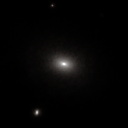

noisy measurement


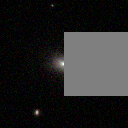

In [14]:
h = 128
w = 128
hcrop, wcrop = h//2, w//2
corner_top, corner_left = h//4, int(0.50*w)
mask = torch.ones((ddpm.imgshape), device=device)
mask[:,:,corner_top:corner_top+hcrop,corner_left:corner_left+wcrop] = 0

def linear_operator(x):
  x = x*mask
  return(x)

idx = 12
#x_true_pil = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/datasets/dummy2/TNG_test_stretched_z=1804/00003.png').convert('RGB')

#x_true = pilimg_to_tensor(x_true_pil)
print(x_true.device)
print("original image", str(idx).zfill(5)+'.png')
display_as_pilimg(x_true[:3])

sigma_noise = 2*10/255

y = linear_operator(x_true.clone()) + sigma_noise * mask * torch.randn_like(x_true)

print("noisy measurement")
display_as_pilimg(y[:,:3]);


  0%|          | 0/999 [00:00<?, ?it/s]

Iteration : 900


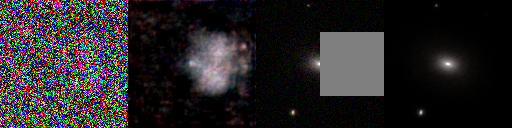

Iteration : 800


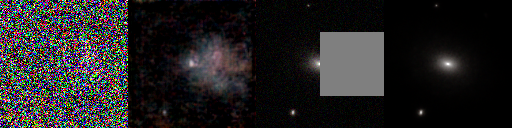

Iteration : 700


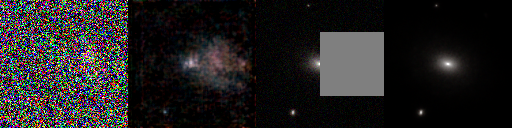

Iteration : 600


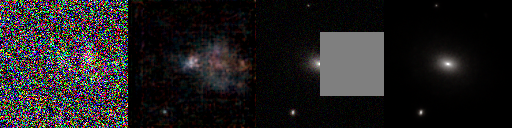

Iteration : 500


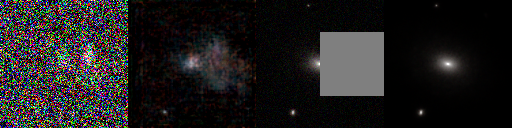

Iteration : 400


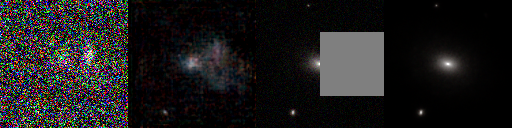

Iteration : 300


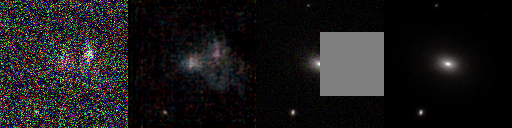

Iteration : 200


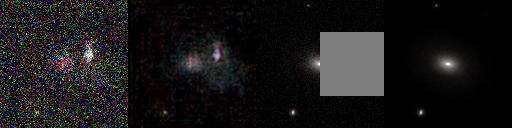

Iteration : 100


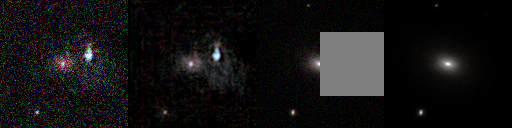

Iteration : 0


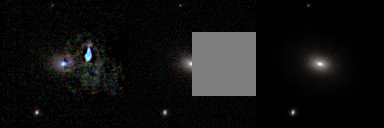

In [15]:
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=True);

## Random inpainting

Device: cuda:0
Original image


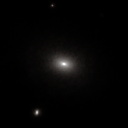

Noisy measurement


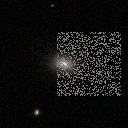

In [41]:
h = 128
w = 128
hcrop, wcrop = h // 2, w // 2
corner_top, corner_left = h // 4, int(0.45 * w)

# Generate a full mask of ones
mask = torch.ones((1, 5, h, w), device='cuda')

# Randomly generate values within the specified area, with each pixel having a 30% chance to be masked
random_mask = torch.rand((1, 1, hcrop, wcrop), device='cuda') > 0.3
mask[:, :, corner_top:corner_top+hcrop, corner_left:corner_left+wcrop] = random_mask.float()

def linear_operator(x):
    x = x * mask
    return x

# Example image loading and conversion
#x_true_pil = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/datasets/dummy2/TNG_test_stretched/00019.png').convert('RGB')  # Update the path accordingly
#x_true = pilimg_to_tensor(x_true_pil)

print("Device:", x_true.device)
print("Original image")
display_as_pilimg(x_true[:3].squeeze(0))

sigma_noise = 2 * 10 / 255

# Apply the linear operator and add noise
y = linear_operator(x_true.clone()) + sigma_noise * mask * torch.randn_like(x_true)

print("Noisy measurement")
display_as_pilimg(y[:,:3].squeeze(0));

In [42]:
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=True);

  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);

In [44]:
def compare_tensor_images(tensor1, tensor2):
    """ Compare two tensor images and return a tensor that represents the differences. """
    # Ensure both tensors are on the same device and have the same dimensions
    tensor1 = tensor1.float()  # Convert to float for subtraction operation
    tensor2 = tensor2.float()
    
    # Compute absolute difference
    diff = torch.abs(tensor1 - tensor2) - 1
    
    # Enhance the difference for better visualization
    diff = diff  # Scale up differences to make them more visible
    return diff

  0%|          | 0/999 [00:00<?, ?it/s]

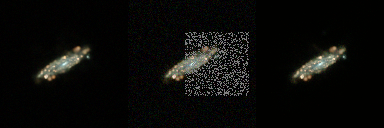

In [23]:
restored_image = ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False)

# Compare tensor images
diff_tensor = compare_tensor_images(restored_image*2 - 1, x_true)

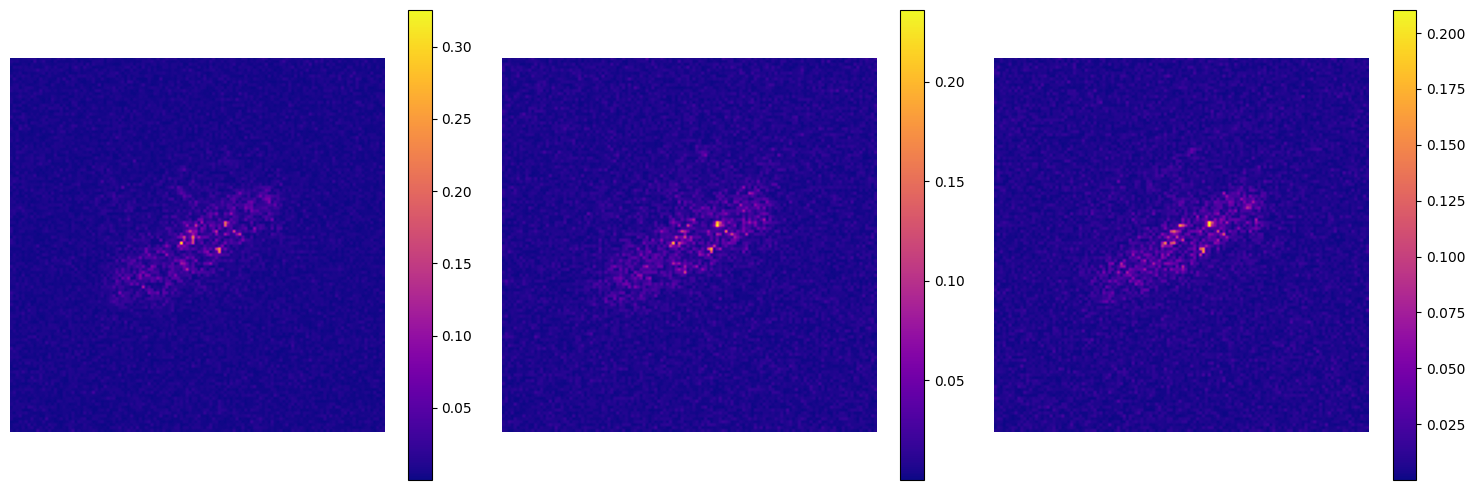

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    img = ((diff_tensor.squeeze(0)[i] + 1) / 2).detach().cpu().numpy()
    im = ax.imshow(img, cmap='plasma')
    ax.axis('off')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

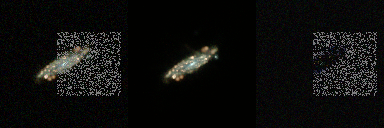

tensor(0.1259, device='cuda:0')


In [25]:
# Compare tensor images
diff_tensor = compare_tensor_images(y, x_true)

# Plot tensor images
display_as_pilimg(torch.cat((y, x_true, diff_tensor), dim=3));

print(torch.mean(diff_tensor+1))

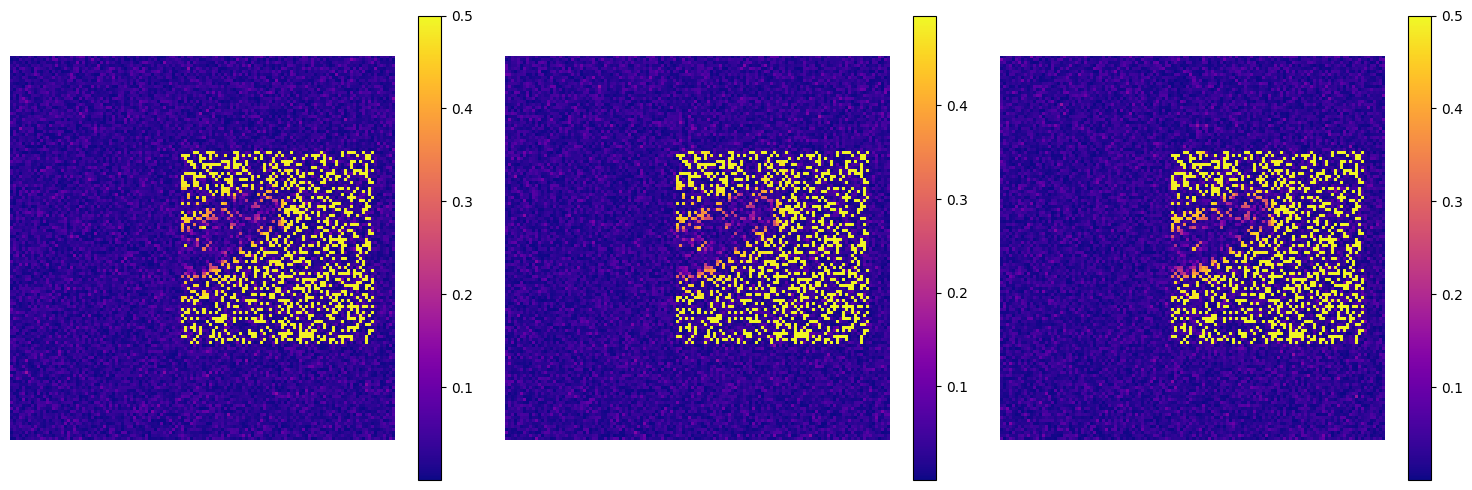

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    img = ((diff_tensor.squeeze(0)[i] + 1) / 2).detach().cpu().numpy()
    im = ax.imshow(img, cmap='plasma')
    ax.axis('off')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## Super-resolution

In [32]:
from torch.nn.functional import interpolate

def linear_operator(x, scale_pct = 0.5):
  x = interpolate(x, scale_factor=(scale_pct, scale_pct))
  x = interpolate(x, scale_factor=(1/scale_pct, 1/scale_pct))
  return x

original image


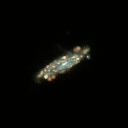

Noisy measurement


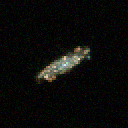

In [28]:
x_true_pil = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/datasets/dummy2/TNG_test_stretched/00019.png').convert('RGB')

x_true = pilimg_to_tensor(x_true_pil)
print("original image")
display_as_pilimg(x_true)

sigma_noise = 2*10/255

# Apply the linear operator and add noise
y = linear_operator(x_true.clone()) + sigma_noise * torch.randn_like(x_true)

print("Noisy measurement")
display_as_pilimg(y.squeeze(0));

In [ ]:
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);
ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=False);

  0%|          | 0/999 [00:00<?, ?it/s]

Iteration : 900


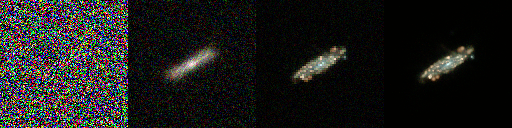

Iteration : 800


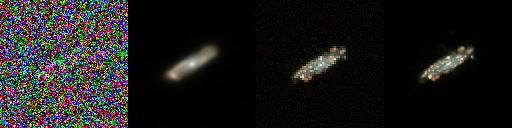

Iteration : 700


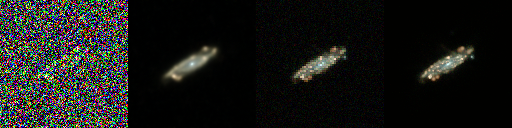

Iteration : 600


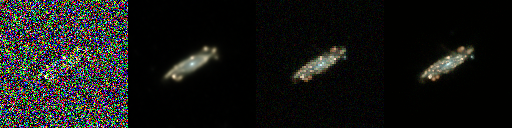

Iteration : 500


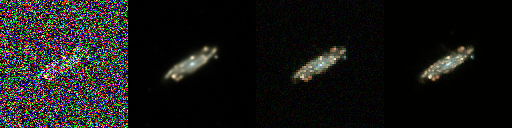

Iteration : 400


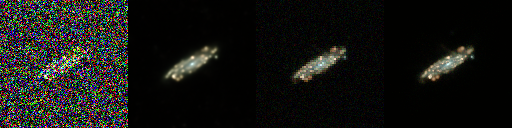

Iteration : 300


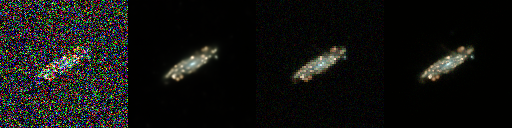

Iteration : 200


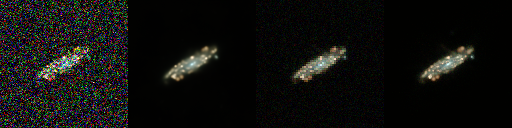

Iteration : 100


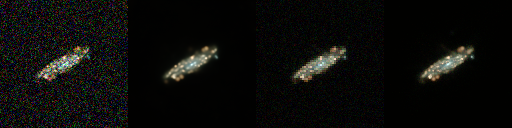

Iteration : 0


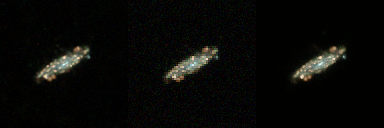

In [29]:
restored_image = ddpm.posterior_sampling(linear_operator, y, x_true=x_true, show_steps=True)

# Compare tensor images
diff_tensor = compare_tensor_images(restored_image, x_true)

## PSF and PSF + gray background

In [12]:
import torch.nn.functional as F

def gaussian_kernel(size, sigma, device):
    """
    Generates a 2D Gaussian kernel on the specified device.
    """
    x_coord = torch.arange(size, device=device) - (size - 1) / 2
    x_grid, y_grid = torch.meshgrid(x_coord, x_coord, indexing='ij')
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    variance = sigma**2
    gaussian = torch.exp(-torch.sum(xy_grid**2., dim=-1) / (2 * variance))
    gaussian /= gaussian.sum()

    return gaussian.view(1, 1, size, size)

def apply_psf_gaussian(x, kernel_size=5, sigmas=[1.5, 1.1, 0.7]):
    """
    Applies different Gaussian PSF to each channel of a tensor x using specified kernel size and sigmas.
    """
    device = x.device  # Get the device from the input tensor
    channels = x.size(1)  # Assuming x has shape [N, C, H, W]

    # Create a multi-channel Gaussian kernel
    # Each channel has a different sigma
    multi_channel_kernel = []
    for i in range(channels):
        kernel = gaussian_kernel(kernel_size, sigmas[i], device)
        multi_channel_kernel.append(kernel)
    multi_channel_kernel = torch.cat(multi_channel_kernel, dim=0)  # Shape [C, 1, kernel_size, kernel_size]

    # Apply convolution using the multi-channel Gaussian kernel
    padding = kernel_size // 2
    x_psf = F.conv2d(x, multi_channel_kernel, padding=padding, groups=channels)

    return x_psf

In [13]:
def apply_psf_and_adjusted_noise(x, kernel_size=5, sigma=1.0, baseline_gray=0.05):
    """
    Applies a Gaussian PSF to a tensor x using a specified kernel size and sigma,
    adds a baseline gray to nearly black pixels, and introduces Gaussian noise.
    """
    device = x.device  # Get the device from the input tensor

    # Generate Gaussian kernel on the correct device
    kernel = gaussian_kernel(kernel_size, sigma, device)

    # The kernel needs to be repeated for each channel
    channels = x.size(1)
    kernel = kernel.repeat(channels, 1, 1, 1)  # Adjust kernel for each input channel

    # Apply convolution using the Gaussian kernel
    # Padding is set to 'same' so the output size is equal to the input size
    padding = kernel_size // 2
    x_psf = F.conv2d(x, kernel, padding=padding, groups=channels)

    # Increase the intensity of near-black pixels to a dark gray level
    mask_dark = (x <= 0.05).float()
    x_psf += mask_dark * baseline_gray

    return x_psf

original image


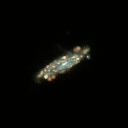

Noisy measurement


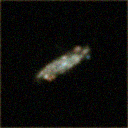

In [14]:
x_true_pil = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/datasets/dummy2/TNG_test_stretched/00019.png').convert('RGB')

x_true = pilimg_to_tensor(x_true_pil)
print("original image")
display_as_pilimg(x_true)

sigma_noise = 2*10/255
#sigma_noise = 1.0

y = apply_psf_gaussian(x_true.clone(), kernel_size=5) + sigma_noise * torch.randn_like(x_true)

print("Noisy measurement")
display_as_pilimg(y.squeeze(0));

  0%|          | 0/999 [00:00<?, ?it/s]

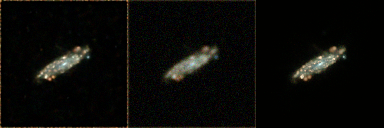

tensor(0.0415, device='cuda:0', grad_fn=<MeanBackward0>)


In [15]:
restored_image = ddpm.posterior_sampling(apply_psf_gaussian, y, x_true=x_true, show_steps=False)

In [ ]:
def crop_tensor(image_tensor, border_size=5):
    """
    Crop the image tensor by removing the specified border size from each edge.
    
    Parameters:
    - image_tensor (torch.Tensor): The input image tensor of shape (C, H, W).
    - border_size (int): The number of pixels to remove from each edge.
    
    Returns:
    - torch.Tensor: The cropped image tensor.
    """
    # Check if the tensor has the right shape (C, H, W)
    if image_tensor.dim() != 3:
        raise ValueError("Input tensor must have 3 dimensions (C, H, W)")
    
    # Get the original dimensions
    _, height, width = image_tensor.shape
    
    # Calculate the new dimensions
    new_height = height - 2 * border_size
    new_width = width - 2 * border_size
    
    # Ensure the new dimensions are positive
    if new_height <= 0 or new_width <= 0:
        raise ValueError("Border size is too large for the given image dimensions")
    
    # Crop the tensor
    cropped_tensor = image_tensor[:, border_size:height-border_size, border_size:width-border_size]
    
    return cropped_tensor

restored_cropped = crop_tensor(restored_image.squeeze(0))
x_true_cropped = crop_tensor(x_true.squeeze(0))
y_cropped = crop_tensor(y.squeeze(0))

In [45]:
# Compare tensor images
diff_tensor = compare_tensor_images(restored_cropped*2 - 1, x_true_cropped)

print(torch.mean(diff_tensor+1))

tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>)


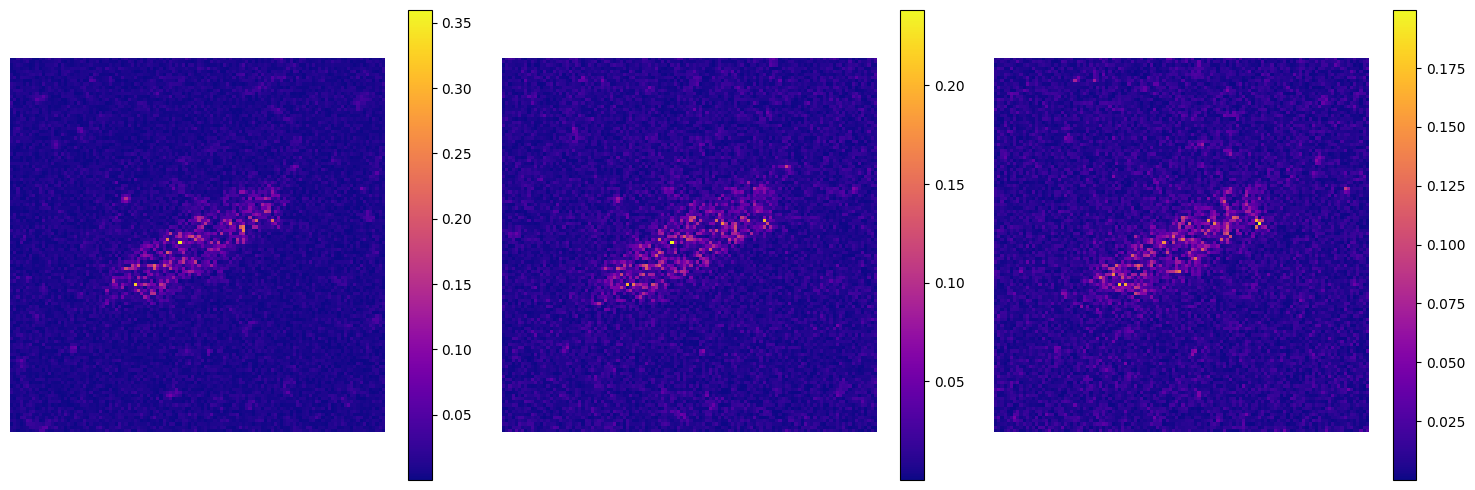

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    img = ((diff_tensor.squeeze(0)[i] + 1) / 2).detach().cpu().numpy()
    im = ax.imshow(img, cmap='plasma')
    ax.axis('off')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

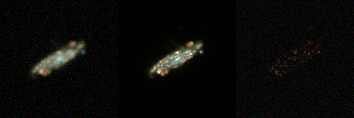

tensor(0.0661, device='cuda:0')


In [50]:
# Compare tensor images
diff_tensor = compare_tensor_images(y_cropped, x_true_cropped)

# Plot tensor images
display_as_pilimg(torch.cat((y_cropped.unsqueeze(0), x_true_cropped.unsqueeze(0), diff_tensor.unsqueeze(0)), dim=3));

print(torch.mean(diff_tensor+1))

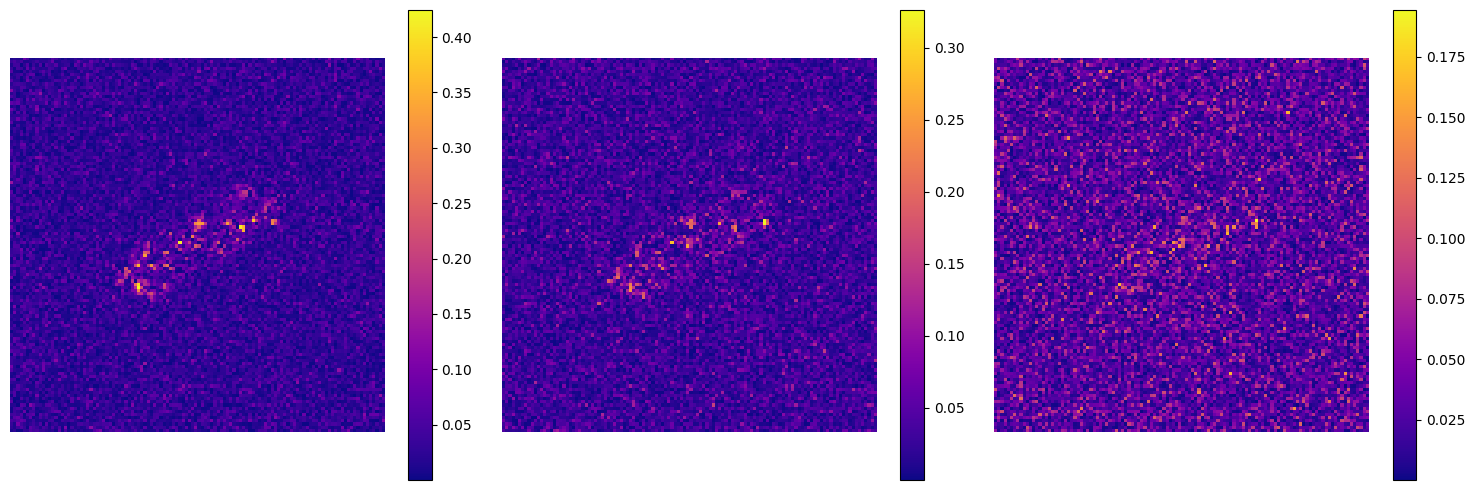

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    img = ((diff_tensor.squeeze(0)[i] + 1) / 2).detach().cpu().numpy()
    im = ax.imshow(img, cmap='plasma')
    ax.axis('off')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [33]:
PSNR_noisy = mypsnr(x_true_cropped,y_cropped)
PSNR_restored = mypsnr(x_true_cropped,restored_cropped*2 - 1)

print("PSNR w.r.t noisy image: ", PSNR_noisy)
print("PSNR w.r.t restored image: ", PSNR_restored)

PSNR w.r.t noisy image:  27.36672599005947
PSNR w.r.t restored image:  34.43038029208876


In [43]:
def compute_image_gradient(image_tensor):
    """ Compute the gradient magnitude of the image tensor. Assumes the tensor is [C, H, W] and in 'float' format. """
    # Normalize from [-1, 1] to [0, 255] if necessary for more standard edge detection handling
    image_tensor = (image_tensor + 1) * 127.5

    # Ensure the image tensor is in float format and has a batch dimension [B, C, H, W]
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0).float()
    elif image_tensor.dim() == 4:
        image_tensor = image_tensor.float()
    
    # Define Sobel filters for x and y gradient
    sobel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]).view((1, 1, 3, 3)).repeat((image_tensor.size(1), 1, 1, 1))
    sobel_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]]).view((1, 1, 3, 3)).repeat((image_tensor.size(1), 1, 1, 1))

    if image_tensor.is_cuda:
        sobel_x = sobel_x.cuda()
        sobel_y = sobel_y.cuda()

    # Convolve with sobel filters
    edge_x = F.conv2d(image_tensor, sobel_x, padding=1, groups=image_tensor.size(1))
    edge_y = F.conv2d(image_tensor, sobel_y, padding=1, groups=image_tensor.size(1))
    
    # Compute gradient magnitude
    magnitude = torch.sqrt(edge_x**2 + edge_y**2).squeeze(0)
    return magnitude

def compute_sharpness_index(image_tensor):
    """ Estimate image sharpness using the gradient magnitude. """
    gradient_magnitude = compute_image_gradient(image_tensor)
    # Adjust threshold considering pixel range is now [0, 255]
    sharpness = torch.sum(gradient_magnitude > 50)  # Adjusted threshold
    return sharpness.item()

def compare_grad(image_tensor1, image_tensor2):
    """ Compare the sharpness of two tensor images. """
    sharpness1 = compute_sharpness_index(image_tensor1)
    sharpness2 = compute_sharpness_index(image_tensor2)

    print(f"Sharpness of Image Tensor 1: {sharpness1}")
    print(f"Sharpness of Image Tensor 2: {sharpness2}")


compare_tensor_images(y_cropped, restored_cropped)

Sharpness of Image Tensor 1: 16466
Sharpness of Image Tensor 2: 3669


## Classical techniques

### Wiener

In [36]:
from skimage import color, data, restoration
from scipy.signal import convolve2d

kernel = gaussian_kernel(5, 1.0, device).squeeze(0).cpu().numpy()
deconvolved_Wien = restoration.wiener(y.squeeze(0).cpu().numpy(), kernel, 0.05)

PSNR_Wiener = mypsnr(x_true.cpu(),torch.from_numpy(deconvolved_Wien))

print("PSNR w.r.t Wiener deconvolved image: ", PSNR_Wiener)

PSNR w.r.t Wiener deconvolved image:  28.770961678484575


Wiener


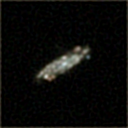

In [37]:
print("Wiener")
display_as_pilimg(torch.from_numpy(deconvolved_Wien));

### Richardson-Lucy

In [38]:
deconvolved_RL = restoration.richardson_lucy(y.squeeze(0).cpu().numpy(), kernel, num_iter=30)

PSNR_RL = mypsnr(x_true.cpu(),torch.from_numpy(deconvolved_RL))

print("PSNR w.r.t RL deconvolved image: ", PSNR_RL)

PSNR w.r.t RL deconvolved image:  18.566026177760428


Richardson - Lucy


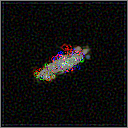

In [39]:
print("Richardson - Lucy")
display_as_pilimg(torch.from_numpy(deconvolved_RL));

### Explicit Regularization - Tychonoff

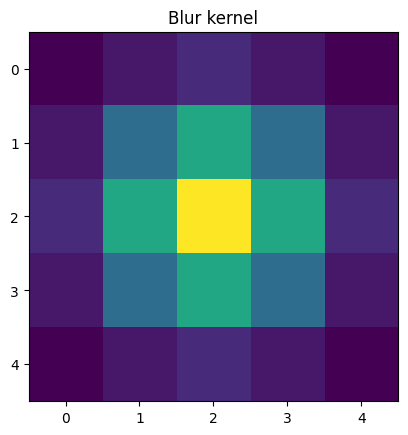

In [26]:
ker = gaussian_kernel(5, 1.0, device).squeeze(0)[0].cpu().numpy()
(m,n) = ker.shape

plt.imshow(ker)
plt.title('Blur kernel')
plt.show()

# Embed the kernel in a MxN image, and put center at pixel (0,0)
k = torch.zeros((128,128))
k[0:m,0:n] = torch.from_numpy(ker)/torch.sum(torch.from_numpy(ker))
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1)).to(device)

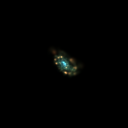

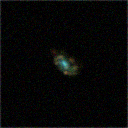

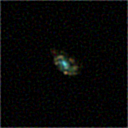

In [27]:
def Ft(u, k, v, lam=1):
    """
    Compute the gradient of the Tychonoff regularized objective function for a single channel.
    """
    u.requires_grad_()

    # Gradient in spatial domain
    du1 = torch.roll(u, shifts=-1, dims=0) - u
    du2 = torch.roll(u, shifts=-1, dims=1) - u

    # Regularization term
    tych = torch.norm(du1)**2 + torch.norm(du2)**2

    # Data fidelity term with convolution (using FFT)
    Fu = 0.5 * torch.norm(torch.real(torch.fft.ifft2(torch.fft.fft2(u) * torch.fft.fft2(k))) - v)**2 + lam * tych

    return torch.autograd.grad(Fu, u)[0]

def process_channel(u_channel, k_channel, v_channel, lam, tau, iterations=1000):
    """
    Apply regularization and update for a single channel.
    """
    for i in range(iterations):
        grad = Ft(u_channel, k_channel, v_channel, lam)
        u_channel = u_channel - tau * grad
    return u_channel.detach()

# Initialize parameters
lam = 0.02
tau = 1 + 16 * lam
v = y.squeeze(0)  # Assuming y is the observed blurred image
u0 = x_true.squeeze(0)  # Assuming x_true is the original image

# Process each channel independently
channels = []
for c in range(3):
    u_channel = torch.zeros_like(v[c])
    v_channel = v[c]
    k_channel = k  # Assuming same kernel for all channels; modify if different per channel
    u_channel = process_channel(u_channel, k_channel, v_channel, lam, tau)
    channels.append(u_channel)

# Combine channels back into a single tensor
u_Tyc = torch.stack(channels, dim=0)

display_as_pilimg(u0);
display_as_pilimg(v);
display_as_pilimg(u_Tyc);

### Explicit Regularization - Total Variation

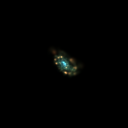

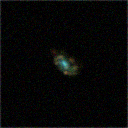

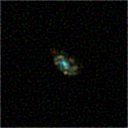

In [28]:
# Write the functional with data-fidelity and regularization with weight lam>0.
def Gt(u, lam=1, ep=0.01):
    u.requires_grad_()

    du1 = torch.roll(u, -1, 0) - u
    du2 = torch.roll(u, -1, 1) - u

    du1sq = torch.square(du1)
    du2sq = torch.square(du2)

    delta = du1sq + du2sq + ep**2

    tych = torch.norm(torch.sqrt(delta), p=1)

    Fu = 0.5*torch.norm(torch.real(torch.fft.ifft2(torch.fft.fft2(u)*torch.fft.fft2(k))) - v)**2 + lam*tych

    return torch.autograd.grad(Fu, u)


def process_channel(u_channel, k_channel, v_channel, lam, tau, iterations=1000):
    """
    Apply regularization and update for a single channel.
    """
    for i in range(iterations):
        grad = Ft(u_channel, k_channel, v_channel, lam)
        u_channel = u_channel - tau * grad
    return u_channel.detach()

# Initialize parameters
lam = 0.02
ep = 0.01
tau = 2/(1+8*lam/ep)

v = y.squeeze(0)  # Assuming y is the observed blurred image
u0 = x_true.squeeze(0)  # Assuming x_true is the original image

# Process each channel independently
channels = []
for c in range(3):
    u_channel = torch.zeros_like(v[c])
    v_channel = v[c]
    k_channel = k  # Assuming same kernel for all channels; modify if different per channel
    u_channel = process_channel(u_channel, k_channel, v_channel, lam, tau)
    channels.append(u_channel)

# Combine channels back into a single tensor
u_TV = torch.stack(channels, dim=0)

display_as_pilimg(u0);
display_as_pilimg(v);
display_as_pilimg(u_TV);

### L2 norms

In [40]:
print(np.sqrt(np.sum((deconvolved_Wien - x_true.squeeze(0).cpu().numpy())**2)))
print(np.sqrt(np.sum((deconvolved_RL - x_true.squeeze(0).cpu().numpy())**2)))
#print(np.sqrt(np.sum((u_Tyc.cpu().numpy() - x_true.squeeze(0).cpu().numpy())**2)))
#print(np.sqrt(np.sum((u_TV.cpu().numpy() - x_true.squeeze(0).cpu().numpy())**2)))

16.152975
52.29971


# Application to actual images

Noisy measurement


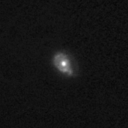

In [31]:
y = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/galaxy_COSMOS_test3.png').convert('RGB')
y = pilimg_to_tensor(y)

print("Noisy measurement")
display_as_pilimg(y.squeeze(0));

  0%|          | 0/999 [00:00<?, ?it/s]

Iteration : 900


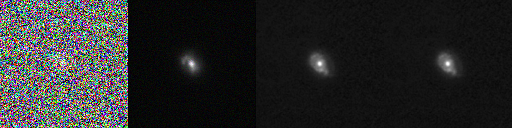

Iteration : 800


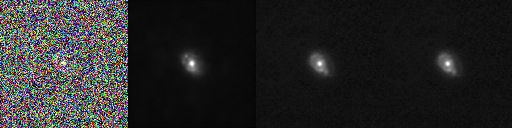

Iteration : 700


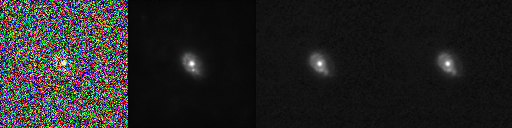

Iteration : 600


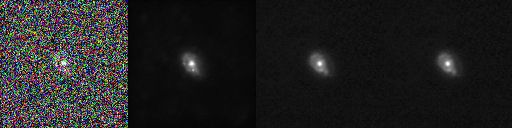

Iteration : 500


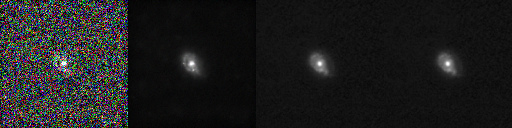

Iteration : 400


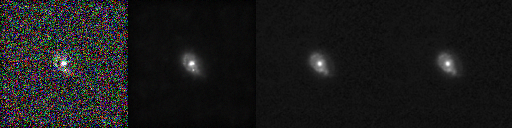

Iteration : 300


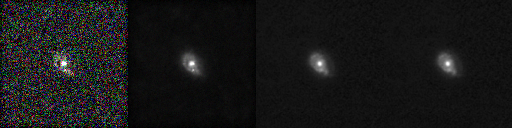

Iteration : 200


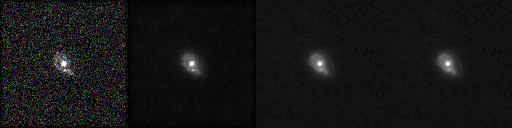

Iteration : 100


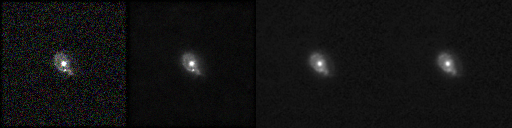

Iteration : 0


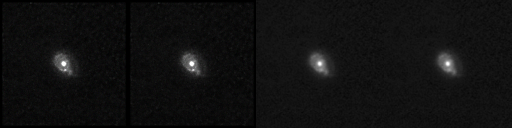

tensor([[[[-1.0014, -0.9996, -1.0063,  ..., -1.0032, -0.9974, -1.0047],
          [-0.9920, -0.9985, -0.9958,  ..., -1.0059, -1.0084, -1.0006],
          [-1.0068, -1.0165, -0.9824,  ..., -0.9597, -1.0021, -0.9972],
          ...,
          [-1.0178, -1.0076, -0.9737,  ..., -0.9438, -0.9940, -1.0076],
          [-0.9880, -1.0012, -0.9924,  ..., -0.9922, -1.0049, -1.0169],
          [-1.0220, -1.0099, -0.9955,  ..., -1.0092, -1.0057, -1.0193]],

         [[-1.0034, -0.9984, -1.0055,  ..., -1.0027, -0.9929, -0.9977],
          [-1.0005, -0.9970, -0.9967,  ..., -1.0082, -1.0021, -1.0086],
          [-1.0001, -1.0015, -0.9676,  ..., -0.9907, -1.0039, -1.0129],
          ...,
          [-0.9966, -1.0135, -0.9824,  ..., -0.9272, -1.0052, -1.0044],
          [-1.0032, -0.9966, -1.0061,  ..., -1.0055, -1.0008, -1.0121],
          [-1.0049, -1.0022, -1.0066,  ..., -0.9985, -1.0143, -0.9918]],

         [[-1.0160, -0.9918, -0.9912,  ..., -0.9969, -0.9961, -0.9940],
          [-1.0096, -1.0012, -

In [43]:
ddpm.posterior_sampling(apply_psf_and_adjusted_noise, y, x_true=y, show_steps=True);

# TNG realistic tests

# Test from fit file

In [8]:
from astropy.io import fits

file = fits.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/shalo_072-2_v0_HSC_GRIZY.fits')

In [ ]:
file[0].header

In [10]:
image_g = file[0].data
image_r = file[4].data
image_i = file[8].data

In [11]:
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize, SinhStretch, LogStretch, LinearStretch, AsinhStretch)

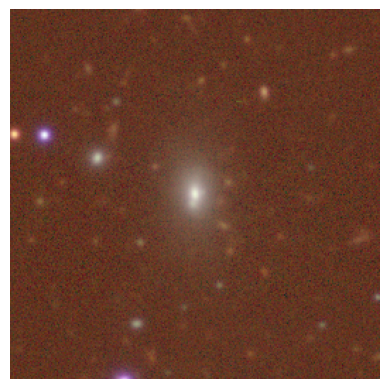

In [17]:
# Normalize each image to [0, 1] scale
r = (image_g - np.min(image_g)) / (np.max(image_g) - np.min(image_g))
g = (image_r - np.min(image_r)) / (np.max(image_r) - np.min(image_r))
b = (image_i - np.min(image_i)) / (np.max(image_i) - np.min(image_i))

interval = MinMaxInterval()
transform = AsinhStretch(a=0.01) + interval

# Apply MinMaxInterval and SqrtStretch to each channel separately
r = transform(r)
g = transform(g)
b = transform(b)

# Stack arrays into a 3D array for RGB image
rgb_image = np.dstack((r, g, b))

# Plot the RGB image
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

In [18]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [19]:
PSF_g = crop_center(file[3].data, 41, 41)
PSF_r = crop_center(file[7].data, 41, 41)
PSF_i = crop_center(file[11].data, 41, 41)

#r = (PSF_g - np.min(PSF_g)) / (np.max(PSF_g) - np.min(PSF_g))
#g = (PSF_r - np.min(PSF_r)) / (np.max(PSF_r) - np.min(PSF_r))
#b = (PSF_i - np.min(PSF_i)) / (np.max(PSF_i) - np.min(PSF_i))

psf_kernel = np.dstack((PSF_g, PSF_r, PSF_i)).transpose((2,0,1))
rgb_image = rgb_image.transpose((2,0,1))

In [20]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import numpy as np

def resize_image_and_kernel(image_tensor, kernel, target_image_size=(128, 128), target_kernel_size=(10, 10)):
    """
    Resize the image tensor and kernel to the specified sizes.
    
    Parameters:
    - image_tensor (torch.Tensor): The input image tensor of shape [N, C, H, W].
    - kernel (np.ndarray): The PSF kernel of shape [C, kernel_size, kernel_size].
    - target_image_size (tuple): The desired size of the output image.
    - target_kernel_size (tuple): The desired size of the output kernel.
    
    Returns:
    - torch.Tensor: The resized image tensor.
    - torch.Tensor: The resized kernel tensor.
    """
    # Resize the image
    resize_transform = transforms.Resize(target_image_size)
    image_tensor_resized = resize_transform(image_tensor)
    
    # Convert the kernel to a PyTorch tensor and resize
    kernel_tensor = kernel.clone().detach().unsqueeze(0).to(image_tensor.device)  # Add batch dimension
    kernel_tensor_resized = TF.center_crop(kernel_tensor, [11, 11])
    kernel_tensor_resized = kernel_tensor_resized.squeeze(0)  # Remove batch dimension
    
    return image_tensor_resized.float(), kernel_tensor_resized.float()

input_image_resized, psf_kernel_resized = resize_image_and_kernel(torch.tensor(rgb_image).to('cuda'), torch.tensor(psf_kernel), target_image_size=(128, 128), target_kernel_size=(11, 11))

def apply_psf_kernel(x, psf_kernel=psf_kernel_resized):
    """
    Applies the provided PSF kernel to each channel of a tensor x.
    
    Parameters:
    - x (torch.Tensor): The input tensor of shape [N, C, H, W].
    - psf_kernel (torch.Tensor): The PSF kernel of shape [C, kernel_size, kernel_size].
    
    Returns:
    - torch.Tensor: The tensor after applying the PSF kernel.
    """

    device = x.device  # Get the device from the input tensor
    channels = x.size(1)  # Assuming x has shape [N, C, H, W]
    
    # Ensure the PSF kernel has the shape [C, 1, kernel_size, kernel_size]
    if psf_kernel.dim() == 3:
        psf_kernel = psf_kernel.unsqueeze(1).to(device)
    
    # Apply convolution using the multi-channel PSF kernel
    kernel_size = psf_kernel.size(2)  # Assuming square kernels
    padding = kernel_size // 2
    x_psf = F.conv2d(x, psf_kernel, padding=padding, groups=channels)
    x_psf = TF.center_crop(x_psf, [128, 128])
    
    return x_psf

original image


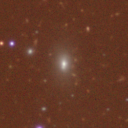

Noisy measurement


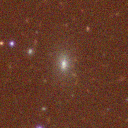

In [21]:
x_true = input_image_resized
x_true = x_true.unsqueeze(0)
print("original image")
display_as_pilimg(x_true*2 - 1)

sigma_noise = 2*5/255
#sigma_noise = 1.0

y = x_true.clone() + sigma_noise * torch.randn_like(x_true)

print("Noisy measurement")
display_as_pilimg(y.squeeze(0)*2 - 1);

  0%|          | 0/999 [00:00<?, ?it/s]

/gpfswork/rech/tkc/uwa51yi/Latent/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Iteration : 900


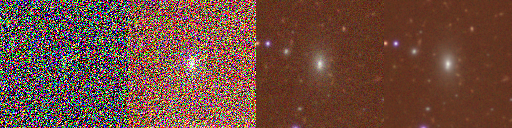

Iteration : 800


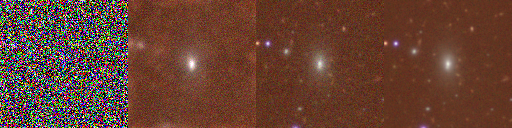

In [22]:
restored_image = ddpm.posterior_sampling(apply_psf_kernel, y*2 - 1, x_true=x_true*2 - 1, show_steps=True)

In [ ]:
# Apply the resized PSF kernel to the resized input image
restored_PSF = apply_psf_kernel(restored_image).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

plt.imshow(restored_PSF)
plt.title("resored with re-added PSF Kernel")
plt.axis('off')
plt.show()

In [21]:
kernel_np = psf_kernel_resized.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

kernel_np = (kernel_np - kernel_np.min())/(kernel_np.max() - kernel_np.min())

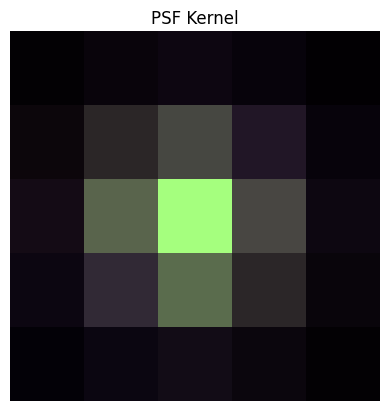

In [22]:
plt.imshow(kernel_np)
plt.title("PSF Kernel")
plt.axis('off')
plt.show()

# Test from PNG

## Load images

In [ ]:
import os
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import os
#plt.style.use(astropy_mpl_style)
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as T

from scipy.ndimage import zoom
import astropy
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.nddata import block_reduce
from astropy.cosmology import Planck15

from random import shuffle
from PIL import Image

pixel_conversion = {}
pixel_conversion['HSC'] = 0.17 * astropy.units.arcsec # arcsec / pixel
pixel_conversion['JWST'] = 0.03 * astropy.units.arcsec # arcsec / pixel

hist_kwargs = {'bins' : 'auto', 'histtype' : 'step', 'density' : True}

# Create an instance of the Planck 2015 cosmology
cosmo = Planck15

def summarize_cosmology():
    # Access various cosmological parameters
    H0 = cosmo.H0  # Hubble constant in km/s/Mpc
    Omega_m = cosmo.Om0  # Matter density parameter
    Omega_lambda = cosmo.Ode0  # Dark energy density parameter

    print("Hubble constant (H0):", H0)
    print("Matter density parameter (Omega_m):", Omega_m)
    print("Dark energy density parameter (Omega_lambda):", Omega_lambda)

def histogram(data, **hist_kwargs):

    data_hist = data.flatten()

    plt.hist(data_hist, **hist_kwargs)

def plot_image(image_data, vmin = None, vmax = None):

    if(vmin == None): vmin = np.min(image_data)
    if(vmax == None): vmax = np.max(image_data)

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)

    plt.imshow(image_data, cmap='jet', vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.close()


def arcsec_to_radian(x):
    return np.pi / 648000 * x

def radian_to_arcsec(x):
    return x / (np.pi / 648000)

def get_down_scale_factor(z = 0.2, unit_pixel_in_kpc = 0.1, experiment = 'HSC'):

    """
    Returns the scale factor at which the image has to be decreased for a given redshift.
    If the scale factor is >1, we decrease the image size.

    """

    arcsec_per_kpc_at_z = Planck15.arcsec_per_kpc_proper(z)

    unit_pixel = unit_pixel_in_kpc * astropy.units.kpc

    down_scale_factor = 1 / unit_pixel * pixel_conversion[experiment] / arcsec_per_kpc_at_z

    if(down_scale_factor.unit == ''):
        return down_scale_factor.value
    else:
        raise "Error, factor carries a unit. "


def magnitude_to_flux_in_janskies(magnitude_values):

    """
    See https://en.wikipedia.org/wiki/AB_magnitude

    """


    return 10 ** ((magnitude_values - 8.9) / (-2.5))


def get_image_in_janski(image_data, z):

    unit_pixel_in_kpc = 0.1

    unit_pixel = unit_pixel_in_kpc * astropy.units.kpc

    pixel_width_in_arcsec = Planck15.arcsec_per_kpc_proper(z) * unit_pixel

    image_in_janskis = pixel_width_in_arcsec.value ** 2 * magnitude_to_flux_in_janskies(image_data)

    return image_in_janskis

def get_downscaled_image_at_z_in_janski(image_data, z, experiment = 'HSC', use_zoom_func = False):

    image_data_in_janski = get_image_in_janski(image_data, z = z)

    reduce_factor = get_down_scale_factor(z, experiment = experiment)

    if(use_zoom_func):
        # Open the image file
        # use zoom function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html
        image_smaller = zoom(image_data_in_janski, 1 / reduce_factor)
    else:
        image_smaller = block_reduce(image_data_in_janski, reduce_factor)

    return image_smaller

def normalize_min_max_func(x):

    x_min = np.min(x)
    x_max = np.max(x)

    return (x - x_min) / (x_max - x_min)


def _ScaleImage(img, z=0.1, experiment='HSC', new_size=128, normalize_min_max=True):
    """
    A function that converts the image as an array to the desired
    """

    rescaled_image = get_downscaled_image_at_z_in_janski(
        image_data=img,
        z=z,
        experiment=experiment,
        use_zoom_func=True
    )

    if not isinstance(rescaled_image, torch.Tensor):
        rescaled_image = torch.from_numpy(rescaled_image) if isinstance(rescaled_image, np.ndarray) else torch.tensor(rescaled_image)

    # Resize and crop or pad the image to the new size
    image_desired_size = TF.resize(rescaled_image.unsqueeze(0), [new_size, new_size])  # resize slightly larger to ensure cropping is possible
    image_desired_size = TF.center_crop(image_desired_size, [new_size, new_size]).squeeze(0).numpy()
    #image_desired_size = TF.resize(image_desired_size, [new_size, new_size]).squeeze(0).numpy()

    if normalize_min_max:
        return normalize_min_max_func(image_desired_size)
    else:
        return image_desired_size

# scaling function
def ScaleImage(img, z = 0.3999, experiment = 'HSC', new_size = 128, normalize_min_max=True):
    return _ScaleImage(img,experiment=experiment,new_size=new_size,z=z, normalize_min_max = normalize_min_max)

class TNGDataset(Dataset):
    def __init__(self, input_dir, band_filters, scaler_function=ScaleImage, device='cpu'):
        self.band_filters = band_filters
        self.scaler_function = scaler_function
        self.data = []
        self.device = device

        # Populate list of FITS files
        for root, dirs, files in os.walk(input_dir, topdown=False):
            for name in files:
                if name.endswith("HSC_GRIZY.fits"):
                    self.data.append(os.path.join(root, name))

        # Shuffle the data to ensure random distribution
        #shuffle(self.data)

        # Split data into training, validation, and test sets
        num_samples = len(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        # Store tensors by filter type
        filter_tensors = {filter_name: None for filter_name in self.band_filters}
        metadata = {}

        with fits.open(file_path) as fitm:
            for fit_elem in fitm:
                extname = fit_elem.header["EXTNAME"]
                if extname in self.band_filters:
                    # Process the image data and convert to a tensor
                    from astropy.visualization import MinMaxInterval, SqrtStretch, LogStretch, AsinhStretch, LinearStretch, PowerStretch, ImageNormalize

                    interval = MinMaxInterval()
                    transform = AsinhStretch(a=1) + interval

                    img = self.scaler_function(fit_elem.data, normalize_min_max=True)
                    img = transform(img)
                    img_tensor = 1 - torch.tensor(img, dtype=torch.float32, device=self.device)

                    # Store tensor in the corresponding filter entry
                    filter_tensors[extname] = img_tensor

                    # Merge metadata from all matched elements
                    metadata.update({
                        "ORIGIN": fit_elem.header["ORIGIN"],
                        "SIMTAG": fit_elem.header["SIMTAG"],
                        "SNAPNUM": fit_elem.header["SNAPNUM"],
                        "SUBHALO": fit_elem.header["SUBHALO"],
                        "CAMERA": fit_elem.header["CAMERA"],
                        "REDSHIFT": fit_elem.header["REDSHIFT"]
                    })

        # Create RGB channels by combining specified filters
        red = filter_tensors['SUBARU_HSC.G']
        green = filter_tensors['SUBARU_HSC.R']
        blue = filter_tensors['SUBARU_HSC.I']
        rgb_image = torch.stack([red, green, blue], dim=0).unsqueeze(0)  # Stack along color channel dimension
        return rgb_image, metadata

def main():
    out_dir = f"/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/realistic_stretched"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    print("loading...")
    dataset = TNGDataset(input_dir='/gpfsstore/rech/tkc/commun/fits_stuff/tng100/72', band_filters=['SUBARU_HSC.G','SUBARU_HSC.R','SUBARU_HSC.I'], device='cuda')

    print("dumping images...")
    transform = T.ToPILImage()
    for i in tqdm(range(len(dataset))):
        rgb_image, _ = dataset[i]
        if rgb_image is not None:
            # Convert the tensor to a PIL Image and save it
            img = transform(rgb_image.squeeze(0))  # Remove batch dimension
            filename = os.path.join(out_dir, f"{i:05d}.png")
            img.save(filename)
        else:
            print(f"Skipping index {i}, no valid image data.")

main()

## Inverse problem

cuda:0


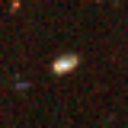

noisy measurement


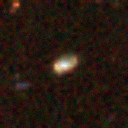

In [14]:
x_true_pil = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/realistic_stretched/00002.png').convert('RGB')

x_true = pilimg_to_tensor(x_true_pil)
print(x_true.device)

display_as_pilimg(x_true)

sigma_noise = 2*5/255

y = x_true.clone() + sigma_noise * torch.randn_like(x_true)
print("noisy measurement")
display_as_pilimg(y);

In [15]:
restored_image = ddpm.posterior_sampling(apply_psf_kernel, y, x_true=x_true, show_steps=True)

NameError: name 'apply_psf_kernel' is not defined